In [10]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D, DepthwiseConv2D, Reshape

In [11]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


In [13]:
tf.test.gpu_device_name()

''

In [9]:
pip install tensorflow-gpu

  Using cached tensorflow_gpu-2.4.0-cp38-cp38-manylinux2010_x86_64.whl (394.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import pip
counter = 0
newpath = "/home/viplabgpu/Documentos/isic-unet/segmentation/Segmentation"
for file in os.listdir(newpath):
    if file.endswith(".png"):
        if file.find("_novice") > -1:
            counter = counter + 1
            os.rename(os.path.join(newpath, file), os.path.join(newpath, file.replace("_novice", "_expert")))
if counter == 0:
    print("No file has been found")

No file has been found


In [15]:
class DataGen(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=28, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#tamanho da sample do treinamento
        self.image_size = image_size#tamanho da img
        self.on_epoch_end()
        
    def __load__(self, id_name):
        
        image_path = os.path.join(self.path, "Images", id_name) + ".jpeg"
        mask_path = os.path.join(self.path, "segmentation/Segmentation", id_name) + "_expert.png"
        
        
        image = cv2.imread(image_path,1)#carregar
        image = cv2.resize(image, (self.image_size, self.image_size))#ajustar tamanho
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        #image = cv2.convertScaleAbs(image, alpha=1.1, beta=0)
        #image = cv2.GaussianBlur(image,(5,5),0)
        #image = cv2.bilateralFilter(image,5,75,75)
        mask = np.zeros((self.image_size, self.image_size, 1))#128*128*1
        _mask = cv2.imread(mask_path, -1)#cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))#ajustar tamanho
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)
        
        #normalizar
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
          _img, _mask = self.__load__(id_name)
          image.append(_img)
          mask.append(_mask)
         
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask   #array
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [16]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [17]:
BACKBONE = 'efficientnetb1'
BATCHS = 28
CLASSES = ['lesion']
LR = 0.001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
image_size = 256
path = "/home/viplabgpu/Documentos/isic-unet/"
train_path = "/home/viplabgpu/Documentos/isic-unet/Images"
batch_size = 28   

train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]#nome do arquivo
train_ids = [i.split('.', 1)[0] for i in train_ids]#-extensao .jpg

val_data_size = 2000#tamanho dataset validação

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]#dividido em 2

In [19]:
gen = DataGen(train_ids, path, batch_size=batch_size, image_size=image_size)#le o treinamento

x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(28, 256, 256, 3) (28, 256, 256, 1)


In [20]:
x[5]

array([[[0.49019608, 0.52156863, 0.55686275],
        [0.49411765, 0.5254902 , 0.55294118],
        [0.49803922, 0.5254902 , 0.55294118],
        ...,
        [0.4627451 , 0.49803922, 0.51372549],
        [0.48627451, 0.49803922, 0.51372549],
        [0.48627451, 0.49411765, 0.51764706]],

       [[0.47843137, 0.52941176, 0.56078431],
        [0.49411765, 0.5254902 , 0.56470588],
        [0.49411765, 0.52941176, 0.55686275],
        ...,
        [0.46666667, 0.49803922, 0.51372549],
        [0.48235294, 0.49411765, 0.50980392],
        [0.51764706, 0.48627451, 0.5254902 ]],

       [[0.47843137, 0.52941176, 0.56470588],
        [0.48627451, 0.52156863, 0.57647059],
        [0.49019608, 0.5254902 , 0.56470588],
        ...,
        [0.4627451 , 0.49019608, 0.51372549],
        [0.47058824, 0.49411765, 0.51372549],
        [0.5254902 , 0.49019608, 0.50588235]],

       ...,

       [[0.47843137, 0.52941176, 0.56078431],
        [0.4745098 , 0.53333333, 0.56470588],
        [0.47058824, 0

10


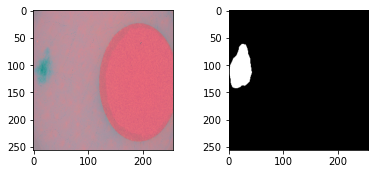

In [21]:
r = random.randint(0, len(x)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [22]:
train_gen = DataGen(train_ids, path)
valid_gen = DataGen(valid_ids, path, 1, 256)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

In [23]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [24]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [26]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./newlab_model.h5', monitor='val_iou_score', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [27]:
hst = model.fit(
    train_gen, 
    steps_per_epoch=train_steps, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_gen, 
    validation_steps=valid_steps,
)

Epoch 1/40
71/71 [==============================] - 412s 6s/step - loss: 0.5679 - iou_score: 0.3396 - f1-score: 0.4901 - val_loss: 4.5822 - val_iou_score: 0.1649 - val_f1-score: 0.2481
Epoch 2/40
71/71 [==============================] - 393s 6s/step - loss: 0.2944 - iou_score: 0.6138 - f1-score: 0.7548 - val_loss: 0.8218 - val_iou_score: 0.2507 - val_f1-score: 0.3203
Epoch 3/40
71/71 [==============================] - 270s 4s/step - loss: 0.2662 - iou_score: 0.6661 - f1-score: 0.7892 - val_loss: 1.0242 - val_iou_score: 0.1350 - val_f1-score: 0.1745
Epoch 4/40
71/71 [==============================] - 270s 4s/step - loss: 0.2629 - iou_score: 0.6613 - f1-score: 0.7882 - val_loss: 0.9078 - val_iou_score: 0.1761 - val_f1-score: 0.2145
Epoch 5/40
71/71 [==============================] - 270s 4s/step - loss: 0.2605 - iou_score: 0.6605 - f1-score: 0.7864 - val_loss: 0.7021 - val_iou_score: 0.3539 - val_f1-score: 0.4399
Epoch 6/40
71/71 [==============================] - 270s 4s/step - loss: 0.

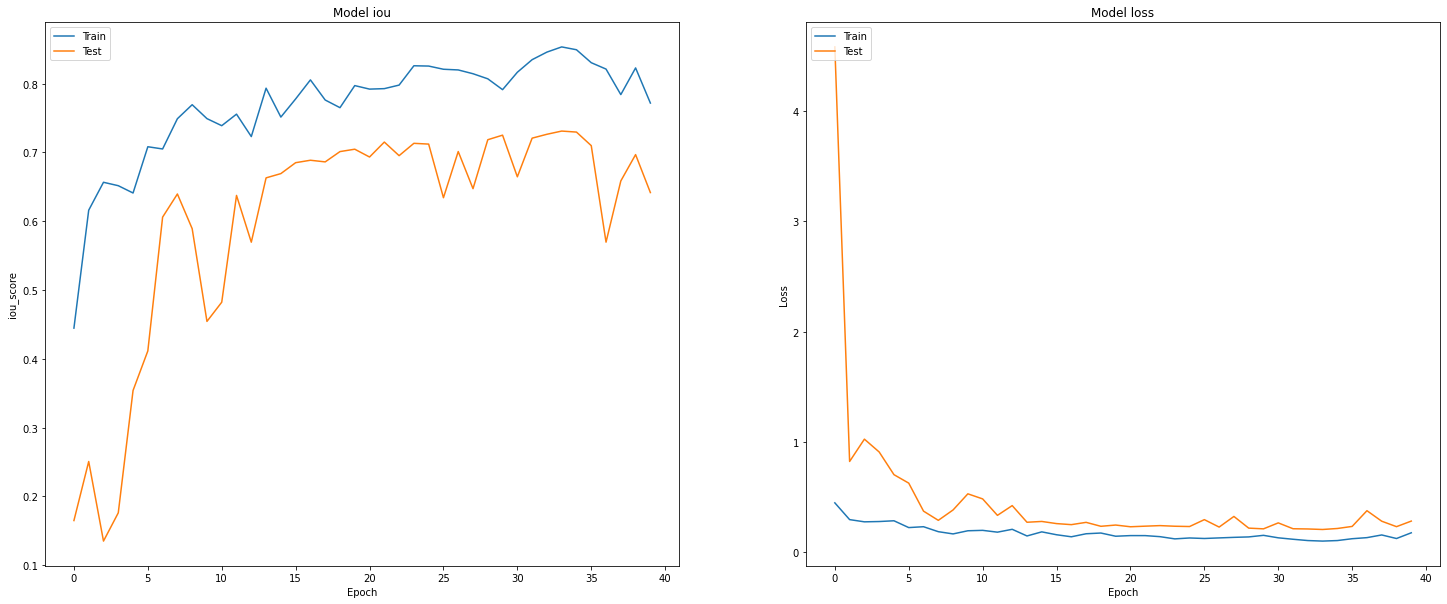

In [28]:
#Plot training & validation iou_score values
plt.figure(figsize=(25, 10))
plt.subplot(121)
plt.plot(hst.history['iou_score'])
plt.plot(hst.history['val_iou_score'])
plt.title('Model iou')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(hst.history['loss'])
plt.plot(hst.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

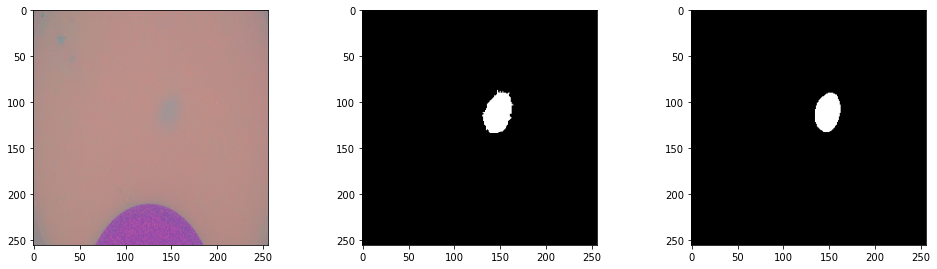

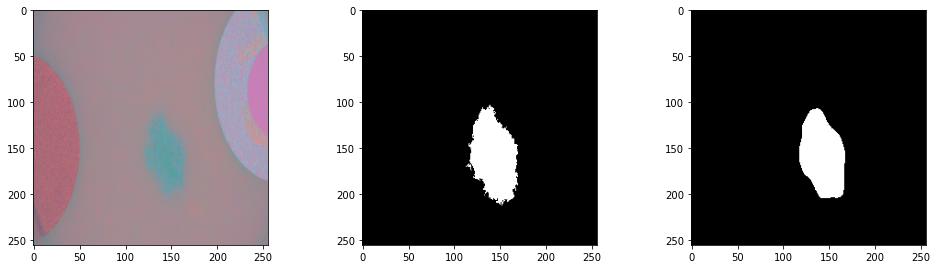

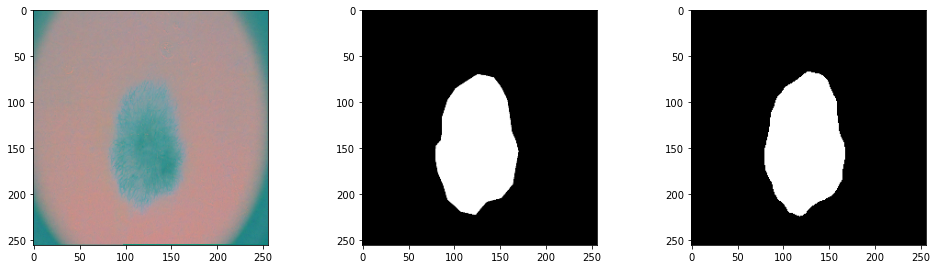

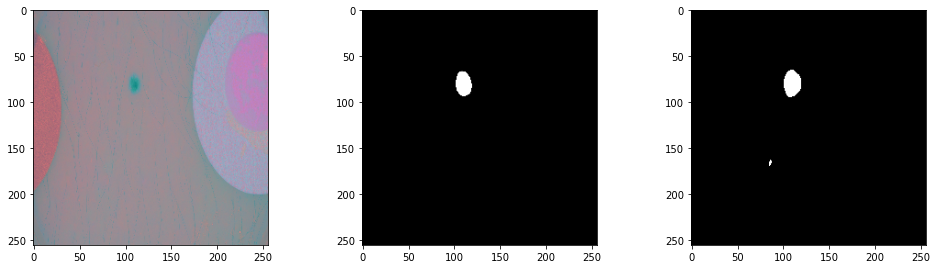

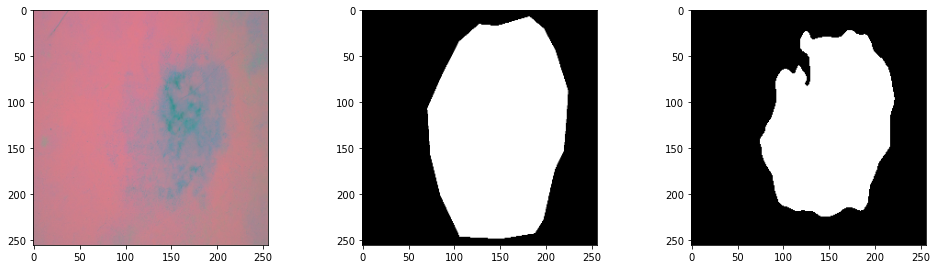

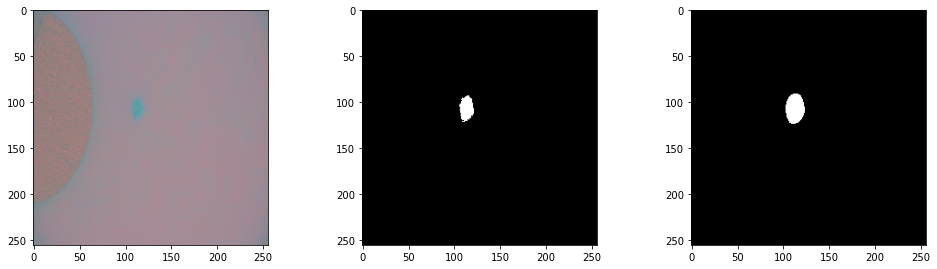

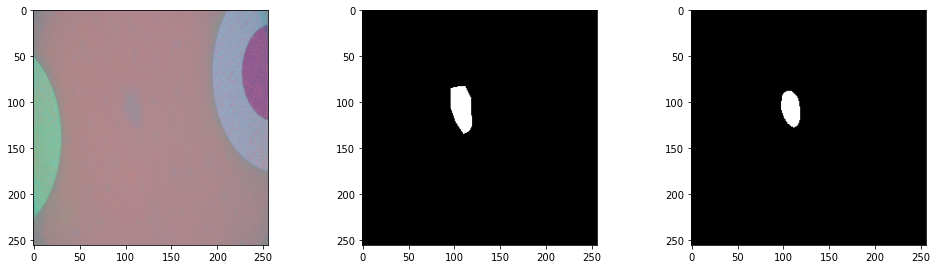

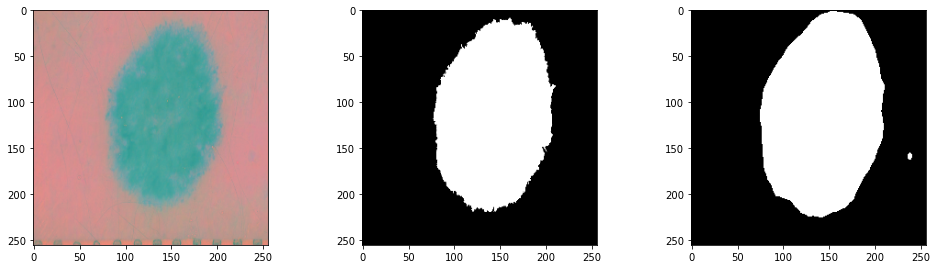

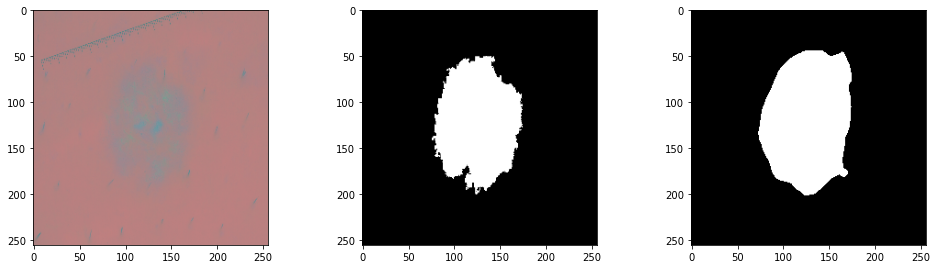

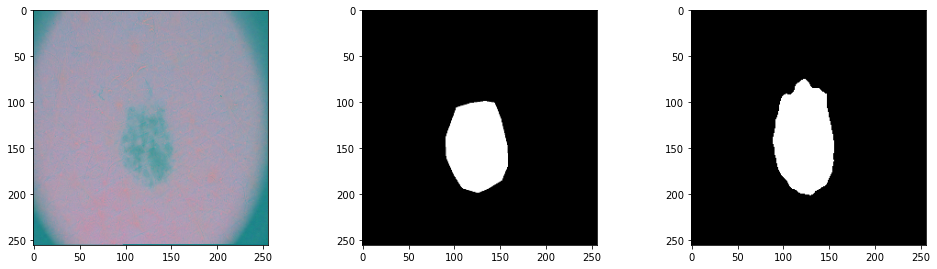

In [40]:
for i in range(0,10):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.4
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard

print(compute_jaccard(y, result))

0.7473087709323026


In [33]:
iouid = []
for i in range(0,len(valid_gen)):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5

    iou = compute_jaccard(y, result)
    if iou < 0.50:
        iouid.append(i)

    print(iou)

0.8374961284111464
0.9001499067914334
0.95977474618237
0.8555044418572998
0.7275195776336901
0.6336457038413461
0.6497276614959898
0.9058763616280441
0.8371399408511628
0.8086452999539623
0.9544125325568755
0.8383973285840407
0.7014831912871775
0.7665089675219181
0.7905366146724823
0.9107156268277938
0.7399661096723658
0.8306582903340965
0.0
0.7570773020838578
0.7944115504335542
0.945077525606606
0.4627375278258429
0.6670080341244686
0.615029460374935
0.8992299341677085
0.403307023290617
0.8146150561046491
0.8470093599527136
0.888815979899913
0.7967698518528282
0.39262013274422825
0.8128159083578993
0.7188800090914442
0.42718381373755626
0.6110236220279993
0.9375088578700266
0.8742203757957367
0.9411963736425569
0.8172825853614254
0.8837552665220906
0.8144088115854107
0.9293542086824332
0.7704574675474866
0.7143496224961701
0.17606318943446525
0.9401200336272748
0.03787768371803746
0.6218609122883193
0.8783280451372731
0.6049688341932682
0.843611515743797
0.0
0.8027472198748329
0.78915

In [32]:
from sklearn.metrics import f1_score

for i in range(0,len(valid_gen)):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
        
    result = result > 0.4

    newy = np.reshape(y, -1)
    newresult = np.reshape(result, -1)

    print(f1_score(newy.astype(int), newresult.astype(int), pos_label = 1, average='binary'))
#print(compute_jaccard(y, result))


0.9296482412060302
0.9546377792823291
0.9785844997279786
0.887816646562123
0.8565173658363411
0.7398843930635839
0.8211330362826225
0.9420747039729347
0.8983571523974889
0.8870940024059117
0.9743864172605872
0.8955223880597015
0.8369322412509307
0.8780971258671952
0.8916525343885434
0.9536142710643676
0.8189806678383129
0.9061297009179746
0.0
0.8742717534298065
0.8937828529998187
0.9720807726075503
0.6793103448275862
0.7757352941176471
0.7871886120996441
0.9509865854111701
0.5579514824797843
0.892296684951109
0.909321984941557
0.9474860335195532
0.8699186991869918
0.5505975727931337
0.8888433141919606
0.824250651369518
0.6251424230915306
0.7317993210109393
0.9657339080879667
0.9296971358092366
0.9709298131717522
0.8937526985286791
0.931810766721044
0.9067758071850842
0.9631760644418872
0.8868613138686132
0.8412698412698413
0.325484039769754
0.9762664816099931
0.09575142675967026
0.7793819353299127
0.9092105263157894
0.7871362940275651
0.9204389574759946
0.0
0.8776781346812327
0.9003783

In [34]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [35]:
    x, y = valid_gen.__getitem__(52)
    result = model.predict(x)
    
    result = result > 0.5

    print(compute_jaccard(y, result))

0.0


In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16524698796545817811
]


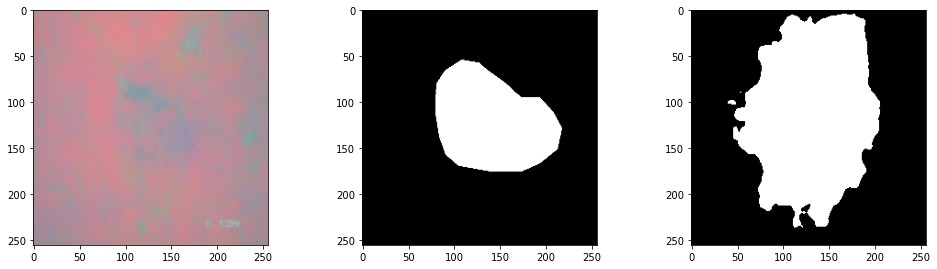

In [37]:
    a, b = valid_gen.__getitem__(359)
    resultado = model.predict(a)
    
    resultado = resultado > 0.4
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(a[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(b[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(resultado[0]*255, (image_size, image_size)), cmap="gray")

    fig.savefig('segmented/graph359lab05.png')

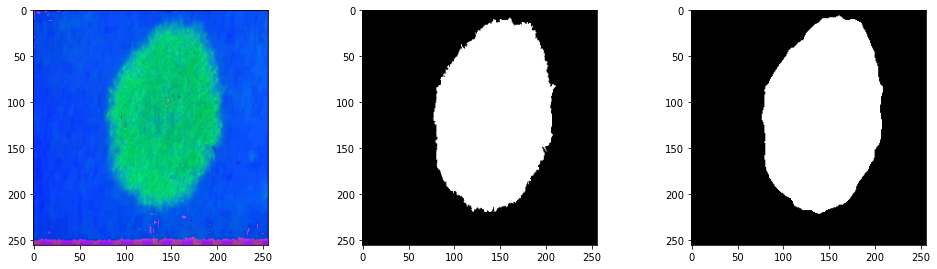

In [56]:
    x, y = valid_gen.__getitem__(7)
    resultado = model.predict(x)

    resultado = resultado > 0.4

    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(resultado[0]*255, (image_size, image_size)), cmap="gray")

In [89]:
print(valid_ids)

['ISIC_0002138', 'ISIC_0003118', 'ISIC_0000340', 'ISIC_0000812', 'ISIC_0010411', 'ISIC_0003172', 'ISIC_0002461', 'ISIC_0000231', 'ISIC_0000492', 'ISIC_0000360', 'ISIC_0000075', 'ISIC_0002290', 'ISIC_0002840', 'ISIC_0001016', 'ISIC_0002469', 'ISIC_0000422', 'ISIC_0001571', 'ISIC_0001171', 'ISIC_0002565', 'ISIC_0002292', 'ISIC_0002828', 'ISIC_0000240', 'ISIC_0001285', 'ISIC_0001271', 'ISIC_0001945', 'ISIC_0000532', 'ISIC_0000608', 'ISIC_0010982', 'ISIC_0000318', 'ISIC_0002774', 'ISIC_0002119', 'ISIC_0013242', 'ISIC_0000579', 'ISIC_0001148', 'ISIC_0001531', 'ISIC_0012288', 'ISIC_0000387', 'ISIC_0011498', 'ISIC_0000368', 'ISIC_0012069', 'ISIC_0001706', 'ISIC_0002006', 'ISIC_0002050', 'ISIC_0002298', 'ISIC_0012075', 'ISIC_0002273', 'ISIC_0002953', 'ISIC_0002816', 'ISIC_0001125', 'ISIC_0002456', 'ISIC_0002547', 'ISIC_0001362', 'ISIC_0001004', 'ISIC_0010746', 'ISIC_0003144', 'ISIC_0001189', 'ISIC_0001987', 'ISIC_0001868', 'ISIC_0001372', 'ISIC_0001159', 'ISIC_0000596', 'ISIC_0000169', 'ISIC_0

In [28]:
for i in range(0,len(valid_gen)):
    x, y = valid_gen.__getitem__(i)
    #result = model.predict(x)
    
    #result = result > 0.5
    print(i, valid_gen.ids[i])

<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
0 ISIC_0002138
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
1 ISIC_0003118
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
2 ISIC_0000340
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
3 ISIC_0000812
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
4 ISIC_0010411
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
5 ISIC_0003172
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
6 ISIC_0002461
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
7 ISIC_0000231
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
8 ISIC_0000492
<bound method DataGen.__getitem__ of <__main__.DataGen object at 0x7feff4698be0>>
9 ISIC_0000360
<bound method DataGen.__getite